# 🧩 Project Overview  

## **Title**  
**Discovering Hidden Barriers to Healthcare Access through Social Listening**

---

## **Goal**  
Use social media conversations (Reddit: *r/BabyBumps, r/pregnant, r/pregnantover35, r/diabetes, r/diabetes_t1, r/diabetes_t2, r/GestationalDiabetes, r/AskDocs, r/HealthInsurance*) to identify hidden barriers that prevent people from seeking care — such as cost, distance, stigma, or bureaucracy — and explore whether those barriers appear to causally influence intent to seek vs. avoid care.

---

## **Value in Addressing**  
Millions share candid health experiences online, yet data remains largely untapped for understanding real-world access challenges.  
By combining unsupervised learning (topic modeling, clustering, and network analysis) with causal inference (estimating whether certain discussions precede shifts in health-seeking intent), this project aims to connect online discourse to public health insights that are scalable, reproducible, and ethically grounded.

---

## **Data Sources**  
Reddit communities collected using the PRAW API:  
*r/BabyBumps, r/pregnant, r/pregnantover35, r/diabetes, r/diabetes_t1, r/diabetes_t2, r/GestationalDiabetes, r/AskDocs, r/HealthInsurance*

---

### **Selected Subreddit Groups**

| Subreddit Group           | Focus                             | Description of Group                                                                 |
| -------------------------- | --------------------------------- | ------------------------------------------------------------------------------------ |
| **r/BabyBumps**           | General pregnancy journey         | Community for expectant mothers sharing experiences, emotional narratives, and challenges related to pregnancy care and prenatal access. |
| **r/pregnant**            | Early-stage pregnancy experiences | Discussion forum covering early pregnancy, first-time parent concerns, high-risk pregnancies, and barriers to accessing prenatal healthcare. |
| **r/pregnantover35**      | Advanced maternal age pregnancy   | Support and discussion group for individuals 35+ navigating pregnancy, fertility, and higher-risk maternal care access challenges. |
| **r/GestationalDiabetes** | Pregnancy-specific diabetes       | Focused on individuals managing gestational diabetes, highlighting the intersection between maternal health and chronic disease management. |
| **r/diabetes**            | General diabetes management       | Broad community addressing chronic disease care, treatment costs, insurance barriers, and ongoing access to healthcare resources. |
| **r/diabetes_t1**         | Type 1 diabetes experiences       | Specialized forum emphasizing the experiences of those with Type 1 diabetes, including insulin affordability, medical technology, and self-management routines. |
| **r/diabetes_t2**         | Type 2 diabetes experiences       | Community focused on lifestyle management, medication access, affordability, and comorbidities associated with Type 2 diabetes. |
| **r/AskDocs**             | Direct health-seeking behavior    | Platform where users seek medical guidance from licensed healthcare professionals, providing insight into real-world intent to seek versus avoid care. |
| **r/HealthInsurance**     | Policy and access navigation      | Community focused on understanding and navigating insurance coverage, denials, affordability, and systemic healthcare access challenges. |

---

## **Supplementary Public Health Datasets (for optional validation)**  
- CDC Behavioral Risk Factor Surveillance System (BRFSS)  
- HRSA Health Resources Data  
- Kaiser Family Foundation (KFF) Health Access Indicators  

These datasets may be used to validate observed trends (e.g., cost or insurance-related barriers) against regional or national health access metrics.  

---

## **Analytic Approach**  
- Unsupervised Learning: Topic modeling, clustering, and barrier co-occurrence network mapping  
- Temporal Trend & Causal Inference: Granger analysis on intent shifts  
- Outcome Focus: Identifying causal relationships between language patterns and healthcare-seeking behavior

---

## **Key Questions to Answer**
1. Which barriers are most frequently cited as reasons for avoiding or delaying care?  
2. Do certain barriers cluster together (e.g., stigma + cost)?  
3. Which linguistic patterns signal implied causality in patient narratives, and how do these patterns align with observed temporal shifts in intent and behavior?
4. Are there hidden or unreported barriers (e.g., partner/family pressure, work schedule conflicts)?  
5. Do different communities (e.g., diabetes vs. pregnancy) experience distinct access challenges?

---


# Data Collection

In [4]:
!pip install praw


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [50]:
import os
import praw

reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent=os.getenv("REDDIT_USER_AGENT"),
    check_for_async=False,
)

print("Read-only mode:", reddit.read_only)

os.makedirs("reports/figures", exist_ok=True)
os.makedirs("reports", exist_ok=True)

Read-only mode: True


In [6]:
import pandas as pd
from datetime import datetime

#Add Subreddit groups to pull
subreddits = ["BabyBumps", "pregnant", "diabetes", "GestationalDiabetes", "diabetes_t1", "diabetes_t2", "pregnantover35", "AskDocs", "HealthInsurance"]
all_posts = []

for sub in subreddits:
    print(f"Collecting from r/{sub}...")
    subreddit = reddit.subreddit(sub)
    for post in subreddit.top(time_filter="year", limit=7000):
        if post.selftext in ["[removed]", "[deleted]", None, ""]:
            continue
        all_posts.append({
            "subreddit": sub,
            "id": post.id,
            "title": post.title,
            "text": post.selftext,
            "created_utc": post.created_utc,
            "created": datetime.utcfromtimestamp(post.created_utc)
        })

/tmp/ipykernel_2033/553858498.py:20: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "created": datetime.utcfromtimestamp(post.created_utc)


In [7]:
#Create dataframe and print
df = pd.DataFrame(all_posts)
print(df["subreddit"].value_counts())
df.to_parquet("reddit_raw.parquet", index=False)

subreddit
pregnant               497
HealthInsurance        496
AskDocs                494
GestationalDiabetes    490
pregnantover35         484
BabyBumps              464
diabetes_t2            461
diabetes               380
diabetes_t1            327
Name: count, dtype: int64


# Data Cleaning

In [8]:
import re

def clean_text(text):
    text = str(text) if text is not None else ""
    text = re.sub(r"http\S+", " ", text)        # remove URLs
    text = re.sub(r"[\r\n]+", " ", text)        # remove newlines
    text = re.sub(r"\s{2,}", " ", text)         # collapse spaces
    return text.strip().lower()

# Combine title + body
df["text_full"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()

# Create cleaned text
df["text_clean"] = df["text_full"].apply(clean_text)

# Optional: drop very short posts
df = df[df["text_clean"].str.len() > 50].copy()

print(df.columns)
df[["subreddit", "text_clean"]].head()

Index(['subreddit', 'id', 'title', 'text', 'created_utc', 'created',
       'text_full', 'text_clean'],
      dtype='str')


,subreddit,text_clean
0,BabyBumps,i caught my cat waking the baby up for food my...
1,BabyBumps,my mil ladies and gents. i'm 4 weeks postpartu...
2,BabyBumps,my manager gave me this after learning my naus...
3,BabyBumps,“penis goes here”- the edgey friend who couldn...
4,BabyBumps,fairy garden nursery done at 37 weeks for our ...


# Barrier & Intent Tagging

In [9]:
# Barrier keyword dictionaries
barriers = {
    "cost": [
        "can't pay", "cannot afford", "couldn't afford",
        "insurance denied", "insurance won't cover",
        "copay", "co-pay",
        "bills", "medical bills",
        "coverage", "lost my coverage",
        "expensive", "too expensive", "too costly",
        "price", "costs too much",
        "out of pocket", "pay out of pocket",
        "deductible", "high deductible",
        "can't afford strips", "can't afford insulin", "can't afford cgm",
        "budget", "financial", "money",
        "unaffordable", "no insurance", "uninsured",
        "out of network",
        "medical debt", "financially struggling",
        "prescription too expensive"
    ],

    "geo": [
        "too far to travel",
        "no transport", "no transportation", "don't have transportation",
        "transportation issues",
        "can't drive", "no ride", "no car",
        "miles away", "far away", "hours away",
        "long drive", "drive hours",
        "can't get there", "can't get to the clinic",
        "clinic too far", "clinic is too far",
        "nearest doctor is far", "nearest is", "closest clinic",
        "rural", "rural area",
        "distance to hospital",
        "travel time", "travel costs",
        "don't live near", "not available in my area"
    ],

    "bureau": [
        "paperwork", "paper work",
        "waitlist", "waiting list",
        "appointment backlog",
        "denied", "denied referral",
        "referral", "can't get a referral",
        "authorization", "prior authorization",
        "red tape",
        "can't get through", "on hold",
        "weeks wait", "months wait", "appointment is months out",
        "couldn't get in", "no availability", "booked out",
        "can't get an appointment", "unable to schedule",
        "impossible to get",
        "gave up calling",
        "got lost in the system",
        "confusing process",
        "don't know where to go",
        "can't find provider",
        "system won't help"
    ],

    "stigma": [
        "stigma", "fear of stigma",
        "embarrassed", "embarrassing",
        "ashamed", "ashamed to ask",
        "shame", "guilty", "blamed myself", "feel like a failure",
        "feel judged", "feeling judged",
        "afraid to ask",
        "don't want people to know", "hiding it", "keeping it secret",
        "scared to tell",
        "family doesn't understand", "family does not understand",
        "partner thinks", "people will think",
        "privacy concerns",
        "afraid to talk about it",
        "worried about discrimination",
        "scared of what doctor will say"
    ],

    "language_info": [
        "language barrier",
        "don't understand instructions",
        "don't understand what they said",
        "too much medical jargon",
        "can't read paperwork",
        "can't read the forms",
        "not explained clearly",
        "hard to follow directions",
        "confusing information",
        "translation issue", "interpreter needed",
        "no materials in my language"
    ],

    "time_work": [
        "can't get time off",
        "can't take time off",
        "work won't let me",
        "no sick leave",
        "no sick days",
        "clinic not open when i can go",
        "clinic not open when I can go",
        "too busy for appointment",
        "too busy to see a doctor",
        "have to work during hours",
        "conflicts with work",
        "can't schedule around job",
        "work schedule conflict",
        "shift work makes it hard",
        "no time for appointment"
    ],

    "trust_mistrust": [
        "don't trust doctor", "do not trust doctor",
        "don't trust hospital", "do not trust hospital",
        "don't trust healthcare", "do not trust healthcare",
        "don't trust medical advice",
        "lost faith in system",
        "healthcare failed me",
        "bad experience before",
        "had a bad experience",
        "wasn't listened to", "was not listened to",
        "doctor ignored me",
        "didn't feel heard", "did not feel heard",
        "they didn't believe me",
        "they don't believe me"
    ]
}

# Care trajectory / intent keywords

barrier_overcome = [
    "finally got", "was able to", "managed to get",
    "insurance approved", "found a way", "worth it in the end",
    "glad I went", "should have gone sooner", "wish I hadn't waited"
]

intent_seek = [
    "booked an appointment", "booked appointment",
    "made an appointment", "have an appointment",
    "seeing my doctor", "seeing the doctor",
    "scheduled a visit", "going next week",
    "going to the doctor", "finally scheduled",
    "got an appointment", "set up appointment",
    "went to see", "visited the doctor",
    "started seeing",
    "got referred", "making an appointment",
    "decided to go"
]

intent_considering = [
    "worth it to see",
    "considering", "considering going",
    "should I", "should i",
    "is it necessary",
    "thinking about", "thinking about going",
    "wondering if I should", "wondering if i should",
    "debating whether"
]

intent_delayed = [
    "bit the bullet",
    "eventually",
    "putting off",
    "finally went",
    "took me weeks",
    "waited too long",
    "delayed"
]

intent_ambivalent = [
    "not sure if",
    "don't know if I should", "don't know if i should",
    "on the fence",
    "hesitant to",
    "reluctant to"
]

intent_avoid = [
    "not going to the doctor", "not going",
    "avoiding the doctor", "avoiding doctors",
    "not worth it",
    "won't go", "will not go",
    "cant go", "can't go",
    "skip the appointment", "skipping",
    "skipped appointment",
    "cancelled appointment", "canceled appointment",
    "rather not",
    "didn't go", "did not go",
    "not bothering",
    "gave up trying",
    "too much hassle",
    "managing on my own",
    "doing it myself"
]

In [10]:
# Tagging functions

def tag_barriers(txt):
    """
    Return a list of barrier categories present in the text.
    Uses simple substring matching; each barrier type is only tagged once.
    """
    txt = txt.lower()
    found = []
    for k, words in barriers.items():
        # Sort longest phrases first to favor more specific matches
        for w in sorted(words, key=len, reverse=True):
            if w.lower() in txt:
                found.append(k)
                break  # Only flag each barrier type once
    # Remove duplicates just in case
    return list(set(found))


def tag_intent(txt):
    """
    Return a single intent label based on priority:
    avoid > delayed > ambivalent > considering > seek
    """
    txt = txt.lower()

    for w in sorted(intent_avoid, key=len, reverse=True):
        if w.lower() in txt:
            return "avoid"

    for w in sorted(intent_delayed, key=len, reverse=True):
        if w.lower() in txt:
            return "delayed"

    for w in sorted(intent_ambivalent, key=len, reverse=True):
        if w.lower() in txt:
            return "ambivalent"

    for w in sorted(intent_considering, key=len, reverse=True):
        if w.lower() in txt:
            return "considering"

    for w in sorted(intent_seek, key=len, reverse=True):
        if w.lower() in txt:
            return "seek"

    return None


def tag_barrier_overcome(txt):
    """
    Return True if any 'barrier_overcome' phrase is present.
    """
    txt = txt.lower()
    for w in sorted(barrier_overcome, key=len, reverse=True):
        if w.lower() in txt:
            return True
    return False


# Apply tagging to the dataframe

print("Tagging barriers...")
df["barriers"] = df["text_clean"].apply(tag_barriers)

print("Tagging intent...")
df["intent"] = df["text_clean"].apply(tag_intent)

print("Tagging barrier_overcome...")
df["barrier_overcome"] = df["text_clean"].apply(tag_barrier_overcome)

# --- Create barrier flags (one per category + overall) ---

df["has_cost"]           = df["barriers"].apply(lambda x: "cost" in x)
df["has_geo"]            = df["barriers"].apply(lambda x: "geo" in x)
df["has_bureau"]         = df["barriers"].apply(lambda x: "bureau" in x)
df["has_stigma"]         = df["barriers"].apply(lambda x: "stigma" in x)
df["has_language_info"]  = df["barriers"].apply(lambda x: "language_info" in x)
df["has_time_work"]      = df["barriers"].apply(lambda x: "time_work" in x)
df["has_trust_mistrust"] = df["barriers"].apply(lambda x: "trust_mistrust" in x)

df["has_any_barrier"]    = df["barriers"].apply(lambda x: len(x) > 0)
df["barrier_count"]      = df["barriers"].apply(len)

Tagging barriers...
Tagging intent...
Tagging barrier_overcome...


# Barrier & Intent Analysis

In [11]:
import pandas as pd

# Analyze and create comprehensive reporting
print("\n" + "=" * 50)
print("BARRIER OVERLAP ANALYSIS")
print("=" * 50)

# Posts with ONLY a single barrier type
only_cost = df["barriers"].apply(lambda x: (len(x) == 1) and ("cost" in x))
only_bureau = df["barriers"].apply(lambda x: (len(x) == 1) and ("bureau" in x))

print(f"\nPosts with ONLY cost barriers: {only_cost.sum()}")
print(f"Posts with ONLY bureau barriers: {only_bureau.sum()}")

# Posts with BOTH cost AND bureau (regardless of other barriers)
both_cost_bureau = df["barriers"].apply(lambda x: ("cost" in x) and ("bureau" in x))
print(f"Posts with BOTH cost AND bureau barriers: {both_cost_bureau.sum()}")

print("\n" + "=" * 50)
print("OVERALL STATISTICS")
print("=" * 50)

print(f"\nTotal posts: {len(df)}")
print(f"Posts with at least one barrier: {df['has_any_barrier'].sum()}")
print(f"Posts with no barriers: {(~df['has_any_barrier']).sum()}")
print(f"Posts with multiple barriers: {df['barriers'].apply(lambda x: len(x) > 1).sum()}")
print(f"Average barriers per post: {df['barriers'].apply(len).mean():.2f}")

print("\n" + "=" * 50)
print("BARRIER TYPE COUNTS")
print("=" * 50)
print(df["barriers"].explode().value_counts())

print("\n" + "=" * 50)
print("INTENT COUNTS")
print("=" * 50)
print(df["intent"].value_counts(dropna=False))

print("\n" + "=" * 50)
print("BARRIER + INTENT CROSSTAB")
print("=" * 50)
print(pd.crosstab(df['has_any_barrier'], df['intent'], dropna=False, margins=True))

print("\n" + "=" * 50)
print("BARRIER COMBINATIONS (Top 10)")
print("=" * 50)

# Use all has_* barrier flags except has_any_barrier
barrier_flag_cols = [
    col for col in df.columns
    if col.startswith("has_") and col not in ["has_any_barrier"]
]

barrier_combos = df.groupby(barrier_flag_cols).size()
print(barrier_combos.sort_values(ascending=False).head(10))

print("\n" + "=" * 50)
print("CAUSAL INDICATORS")
print("=" * 50)

if df['has_any_barrier'].sum() > 0:
    avoid_with_barrier = df[df['has_any_barrier'] & (df['intent'] == 'avoid')].shape[0]
    total_with_barrier = df['has_any_barrier'].sum()
    print(f"Avoid rate WITH barriers: {avoid_with_barrier / total_with_barrier * 100:.1f}%")

if (~df['has_any_barrier']).sum() > 0:
    avoid_without_barrier = df[~df['has_any_barrier'] & (df['intent'] == 'avoid')].shape[0]
    total_without_barrier = (~df['has_any_barrier']).sum()
    print(f"Avoid rate WITHOUT barriers: {avoid_without_barrier / total_without_barrier * 100:.1f}%")

# Save tagged data
df.to_parquet("reddit_tagged.parquet", index=False)
print("\n✅ Data saved to reddit_tagged.parquet")


BARRIER OVERLAP ANALYSIS

Posts with ONLY cost barriers: 435
Posts with ONLY bureau barriers: 89
Posts with BOTH cost AND bureau barriers: 76

OVERALL STATISTICS

Total posts: 4063
Posts with at least one barrier: 813
Posts with no barriers: 3250
Posts with multiple barriers: 100
Average barriers per post: 0.23

BARRIER TYPE COUNTS
barriers
cost      530
stigma    174
bureau    167
geo        47
Name: count, dtype: int64

INTENT COUNTS
intent
NaN            3470
considering     273
delayed         123
avoid            91
ambivalent       57
seek             49
Name: count, dtype: int64

BARRIER + INTENT CROSSTAB
intent           ambivalent  avoid  considering  delayed  seek   NaN   All
has_any_barrier                                                           
False                    45     61          203       93    34  2814  3250
True                     12     30           70       30    15   656   813
All                      57     91          273      123    49  3470  4063

BAR

In [12]:
# Run analysis to analyze posts by barrier type

barrier_types = [
    "cost",
    "geo",
    "bureau",
    "stigma",
    "language_info",
    "time_work",
    "trust_mistrust"
]

for barrier_type in barrier_types:
    flag_col = f"has_{barrier_type}"
    if flag_col not in df.columns:
        # Skip gracefully if a flag wasn't created for some reason
        continue

    subset = df[df[flag_col]]

    print(f"\n{barrier_type.upper()} barrier breakdown:")
    print(f"  Total posts: {len(subset)}")

    with_intent = subset["intent"].notna().sum()
    print(f"  With intent: {with_intent}")

    if with_intent > 0:
        print(subset["intent"].value_counts(dropna=False))

    if len(subset) > 0:
        avoid_rate = (subset["intent"] == "avoid").sum() / len(subset) * 100
        print(f"  Avoid rate: {avoid_rate:.1f}%")


COST barrier breakdown:
  Total posts: 530
  With intent: 93
intent
NaN            437
considering     44
avoid           22
delayed         12
seek             9
ambivalent       6
Name: count, dtype: int64
  Avoid rate: 4.2%

GEO barrier breakdown:
  Total posts: 47
  With intent: 15
intent
NaN            32
delayed         7
considering     6
avoid           1
seek            1
Name: count, dtype: int64
  Avoid rate: 2.1%

BUREAU barrier breakdown:
  Total posts: 167
  With intent: 36
intent
NaN            131
considering     13
delayed          8
avoid            6
ambivalent       5
seek             4
Name: count, dtype: int64
  Avoid rate: 3.6%

STIGMA barrier breakdown:
  Total posts: 174
  With intent: 37
intent
NaN            137
considering     19
avoid            7
seek             5
delayed          4
ambivalent       2
Name: count, dtype: int64
  Avoid rate: 4.0%

LANGUAGE_INFO barrier breakdown:
  Total posts: 0
  With intent: 0

TIME_WORK barrier breakdown:
  Total post

# Sentiment Analysis

In [13]:
!pip install nltk


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [14]:
#Run sentiment analysis using Vader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

nltk.download('vader_lexicon', quiet=True)
sid = SentimentIntensityAnalyzer()

# Create Sentiment column
df["sentiment_score"] = df["text"].fillna("").apply(
    lambda x: sid.polarity_scores(str(x))["compound"]
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# Sentiment distribution
print("\n" + "=" * 50)
print("SENTIMENT DISTRIBUTION")
print("=" * 50)
print(df["sentiment_score"].describe())

# Sentiment by label
def label_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment_score"].apply(label_sentiment)
print(df["sentiment_label"].value_counts())

# Average sentiment by barrier type
print("\n" + "=" * 50)
print("AVERAGE SENTIMENT BY BARRIER")
print("=" * 50)
for barrier in ["cost", "geo", "bureau", "stigma",
                "language_info", "time_work", "trust_mistrust"]:
    mask = df[f"has_{barrier}"]
    if mask.any():
        mean_score = df.loc[mask, "sentiment_score"].mean()
        print(f"{barrier:15}: {mean_score:6.3f}  (n={mask.sum()})")

# Average sentiment by intent
print("\n" + "=" * 50)
print("AVERAGE SENTIMENT BY INTENT")
print("=" * 50)
print(df.groupby("intent")["sentiment_score"].mean().sort_values())


SENTIMENT DISTRIBUTION
count    4063.000000
mean        0.197753
std         0.745877
min        -0.998900
25%        -0.610800
50%         0.475300
75%         0.909800
max         0.999500
Name: sentiment_score, dtype: float64
sentiment_label
positive    2436
negative    1468
neutral      159
Name: count, dtype: int64

AVERAGE SENTIMENT BY BARRIER
cost           :  0.091  (n=530)
geo            :  0.082  (n=47)
bureau         : -0.054  (n=167)
stigma         : -0.017  (n=174)

AVERAGE SENTIMENT BY INTENT
intent
considering    0.046359
seek           0.094931
avoid          0.144581
delayed        0.282250
ambivalent     0.306261
Name: sentiment_score, dtype: float64


# Unsupervised Models (LDA & BERTopic)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize text
texts = df["text_clean"].fillna("")

vectorizer = CountVectorizer(
    max_df=0.95,        # ignore very common words
    min_df=10,          # ignore very rare words
    stop_words="english"
)
dtm = vectorizer.fit_transform(texts)

# Fit LDA
n_topics = 10
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)
lda_doc_topic = lda.fit_transform(dtm)

# Assign dominant LDA topic per post
df["lda_topic"] = lda_doc_topic.argmax(axis=1)

In [17]:
import numpy as np

#Top LDA topics
feature_names = vectorizer.get_feature_names_out()

def print_lda_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_indices]
        print(f"\nTopic {topic_idx}:")
        print(", ".join(top_words))

print_lda_topics(lda, feature_names, n_top_words=12)


Topic 0:
just, like, eat, feel, want, weeks, don, food, pregnancy, ve, baby, day

Topic 1:
baby, just, pain, like, birth, time, feel, don, felt, husband, hours, got

Topic 2:
doctor, cancer, exam, type, patient, necessary, cells, ve, said, months, breast, office

Topic 3:
did, thank, im, normal, weeks, help, know, scan, doctors, days, heart, symptoms

Topic 4:
diabetes, just, sugar, a1c, ve, blood, diet, diagnosed, eat, diabetic, type, day

Topic 5:
weeks, baby, insulin, gd, blood, hours, day, birth, pregnancy, sugar, got, time

Topic 6:
insurance, health, just, plan, pay, year, care, month, don, hospital, healthcare, going

Topic 7:
just, like, baby, pregnant, don, know, feel, want, ve, husband, time, people

Topic 8:
just, said, doctor, like, went, told, weeks, got, did, blood, didn, hospital

Topic 9:
baby, ob, hospital, weeks, induction, birth, said, got, came, section, labor, didn


In [18]:
!pip install bertopic[visualization] umap-learn hdbscan


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [19]:
from bertopic import BERTopic
print("BERTopic imported successfully ✅")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BERTopic imported successfully ✅


In [20]:
# Initialize and fit the model
topic_model = BERTopic(language="english", calculate_probabilities=True)

# Fit to your cleaned text column (replace with your actual text column)
topics, probs = topic_model.fit_transform(df["text_clean"].dropna())

# Add results back to dataframe for analysis
df["topic"] = topics
df["topic_probability"] = probs.max(axis=1)

Loading weights: 100%|██████████| 103/103 [00:01<00:00, 61.29it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [21]:
#BERTopic analysis
print("\n" + "="*50)
print("BERTopic Summary")
print("="*50)

# Total topics (excluding -1 "outliers")
num_topics = len(set(df["topic"])) - (1 if -1 in df["topic"].unique() else 0)
print(f"Total topics (excluding outliers): {num_topics}")
print(f"Outlier posts: {(df['topic'] == -1).sum()}")

# Top 10 most frequent topics
print("\nTop 10 topics by frequency:")
print(df["topic"].value_counts().head(10))



BERTopic Summary
Total topics (excluding outliers): 2
Outlier posts: 0

Top 10 topics by frequency:
topic
0    3555
1     508
Name: count, dtype: int64


In [22]:
#Parameter tune for better output
topic_model = BERTopic(
    language="english",
    min_topic_size=20,      # smaller = more granular clusters
    nr_topics=None,         # keep dynamic, or set an upper limit
    n_gram_range=(1, 2),    # include bigrams
    calculate_probabilities=True
)
topics, probs = topic_model.fit_transform(df["text_clean"])

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 608.67it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


# Integrated Comparison

In [23]:
# Get top keywords for each topic
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

# Display keywords for a specific topic (e.g., topic 0)
topic_id = 0
print(f"\nTop words for topic {topic_id}:")
print(topic_model.get_topic(topic_id))

# Show a few representative posts from that topic
sample_posts = df[df["topic"] == topic_id].sample(5)
print(sample_posts[["subreddit", "intent", "barriers", "sentiment_label", "text_clean"]])

   Topic  Count                    Name  \
0      0   3554         0_and_to_the_my   
1      1    509  1_the_to_and_insurance   

                                      Representation  \
0     [and, to, the, my, was, of, it, in, for, that]   
1  [the, to, and, insurance, for, is, my, of, tha...   

                                 Representative_Docs  
0  [graduated 39w2d been meaning to post this but...  
1  [newborn wrongfully hospitalized due to provid...  

Top words for topic 0:
[('and', np.float64(0.060323727691984026)), ('to', np.float64(0.05459499511831962)), ('the', np.float64(0.050342212597439574)), ('my', np.float64(0.043400319209064446)), ('was', np.float64(0.030189800348854264)), ('of', np.float64(0.029908407845825834)), ('it', np.float64(0.027145129099460846)), ('in', np.float64(0.025974044827587823)), ('for', np.float64(0.0248730040610045)), ('that', np.float64(0.02379843305929303))]
           subreddit   intent  barriers sentiment_label  \
2591     diabetes_t2      NaN 

In [24]:
#Compare LDA with BERTopic + barriers/intent
import pandas as pd

print("\nLDA topic counts:")
print(df["lda_topic"].value_counts().head())

print("\nLDA topic × BERTopic topic (small sample):")
print(pd.crosstab(df["lda_topic"], df["topic"]).head())

print("\nAverage sentiment per LDA topic:")
print(df.groupby("lda_topic")["sentiment_score"].mean().sort_values())

print("\nAverage cost barrier presence per LDA topic:")
print(df.groupby("lda_topic")["has_cost"].mean().sort_values(ascending=False).head())

print("\nIntent by LDA topic:")
print(pd.crosstab(df["lda_topic"], df["intent"], normalize="index"))


LDA topic counts:
lda_topic
7    1019
4     836
6     542
8     464
1     317
Name: count, dtype: int64

LDA topic × BERTopic topic (small sample):
topic        0  1
lda_topic        
0          313  1
1          317  0
2           56  8
3          181  3
4          835  1

Average sentiment per LDA topic:
lda_topic
8   -0.053054
6   -0.008367
3    0.010541
2    0.078395
0    0.123096
1    0.250459
7    0.271178
4    0.312169
5    0.499881
9    0.614864
Name: sentiment_score, dtype: float64

Average cost barrier presence per LDA topic:
lda_topic
6    0.645756
7    0.090285
2    0.062500
1    0.050473
0    0.047771
Name: has_cost, dtype: float64

Intent by LDA topic:
intent     ambivalent     avoid  considering   delayed      seek
lda_topic                                                       
0            0.074074  0.111111     0.629630  0.148148  0.037037
1            0.092593  0.185185     0.333333  0.314815  0.074074
2            0.000000  0.000000     0.625000  0.250000  0.125000

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Topic word embeddings coherence
topics_dict = topic_model.get_topics()
coherence_scores = {}
for t, words in topics_dict.items():
    if t == -1:  # Skip outliers
        continue
    embeddings = [topic_model.embedding_model.embed(word) for word, _ in words[:10]]
    sims = cosine_similarity(embeddings)
    coherence_scores[t] = np.mean(sims[np.triu_indices_from(sims, 1)])

print("\nApproximate topic coherence (top 10):")
print(sorted(coherence_scores.items(), key=lambda x: x[1], reverse=True)[:10])


Approximate topic coherence (top 10):
[(0, np.float32(0.4385839)), (1, np.float32(0.38954765))]


In [26]:
#Barrier & Intent Crossover by Topic
print("\n" + "="*50)
print("TOPIC vs BARRIER / INTENT RELATIONSHIP")
print("="*50)

# Barrier overlap by topic
for barrier in ["cost", "geo", "bureau", "stigma",
                "language_info", "time_work", "trust_mistrust"]:
    col = f"has_{barrier}"
    if col in df.columns:
        mean_val = df.groupby("topic")[col].mean().rename(f"{barrier}_rate")
        print(f"\nAverage {barrier} presence by topic:")
        print(mean_val.sort_values(ascending=False).head(10))

# Intent breakdown by topic
intent_ct = pd.crosstab(df["topic"], df["intent"], normalize="index")
print("\nIntent distribution by topic:")
print(intent_ct.head(10))


TOPIC vs BARRIER / INTENT RELATIONSHIP

Average cost presence by topic:
topic
1    0.671260
0    0.053165
Name: cost_rate, dtype: float64

Average geo presence by topic:
topic
1    0.011811
0    0.011533
Name: geo_rate, dtype: float64

Average bureau presence by topic:
topic
1    0.173228
0    0.022222
Name: bureau_rate, dtype: float64

Average stigma presence by topic:
topic
0    0.048101
1    0.005906
Name: stigma_rate, dtype: float64

Average language_info presence by topic:
topic
0    0.0
1    0.0
Name: language_info_rate, dtype: float64

Average time_work presence by topic:
topic
0    0.0
1    0.0
Name: time_work_rate, dtype: float64

Average trust_mistrust presence by topic:
topic
0    0.0
1    0.0
Name: trust_mistrust_rate, dtype: float64

Intent distribution by topic:
intent  ambivalent     avoid  considering   delayed      seek
topic                                                        
0         0.104364  0.151803     0.447818  0.212524  0.083491
1         0.030303  0.1666

In [27]:
#Sentiment Relationship by Topic
topic_sentiment = (
    df.groupby("topic")["sentiment_score"]
      .agg(["mean", "count"])
      .sort_values("mean")
)
print(topic_sentiment.head(10))

           mean  count
topic                 
1     -0.004455    508
0      0.226648   3555


# Visualizations & Interpretations

In [28]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Create figures directory
os.makedirs("figures", exist_ok=True)

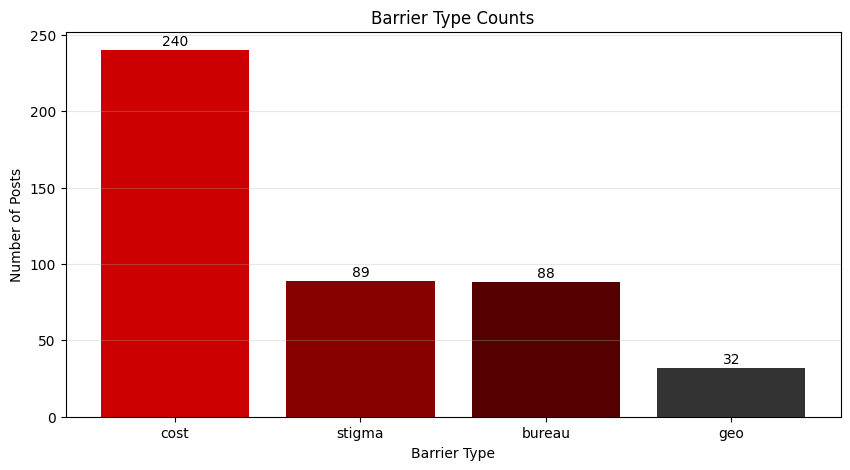

In [29]:
# From stats printout:
barriers = ["cost", "stigma", "bureau", "geo"]
counts   = [240, 89, 88, 32]

plt.figure(figsize=(10,5))
bars = plt.bar(barriers, counts, color=['#cc0000','#880000','#550000','#333333'])

# formatting
plt.title("Barrier Type Counts")
plt.ylabel("Number of Posts")
plt.xlabel("Barrier Type")

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 3,
             '%d' % int(height), ha='center')

# Light horizontal grid
plt.grid(axis='y', alpha=0.3)

plt.show()

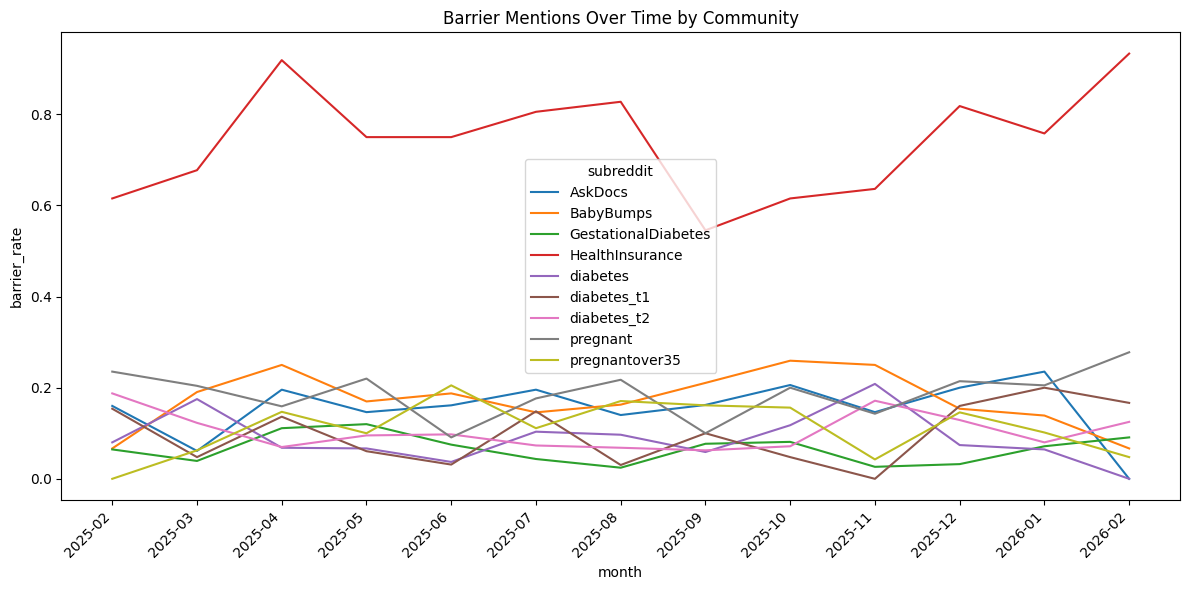

In [30]:
# Topic and Barrier Trends over Time
df['month'] = df['created'].dt.to_period('M').astype(str)
barrier_trends = (
    df.groupby(['subreddit', 'month'])
      .agg(barrier_rate=('has_any_barrier', 'mean'),
           cost_rate=('has_cost', 'mean'),
           stigma_rate=('has_stigma', 'mean'),
           n_posts=('id', 'count'))
      .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(data=barrier_trends, x='month', y='barrier_rate', hue='subreddit')
plt.title("Barrier Mentions Over Time by Community")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/barrier_trends_by_community.png", dpi=300)
plt.show()

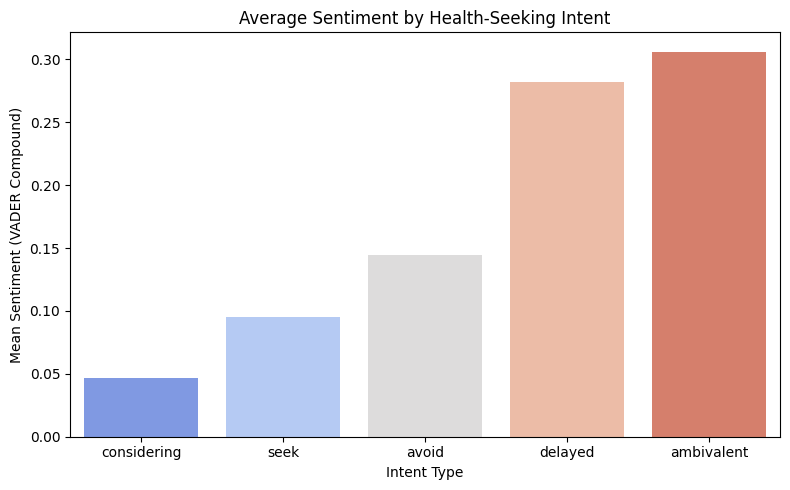

In [31]:
# Sentiment vs Intent
sent_intent = (
    df.groupby('intent')['sentiment_score']
      .mean()
      .reset_index()
      .sort_values('sentiment_score')
)

plt.figure(figsize=(8,5))
sns.barplot(data=sent_intent, x='intent', y='sentiment_score', palette='coolwarm')
plt.title("Average Sentiment by Health-Seeking Intent")
plt.ylabel("Mean Sentiment (VADER Compound)")
plt.xlabel("Intent Type")
plt.tight_layout()
plt.savefig("figures/sentiment_by_intent.png", dpi=300)
plt.show()

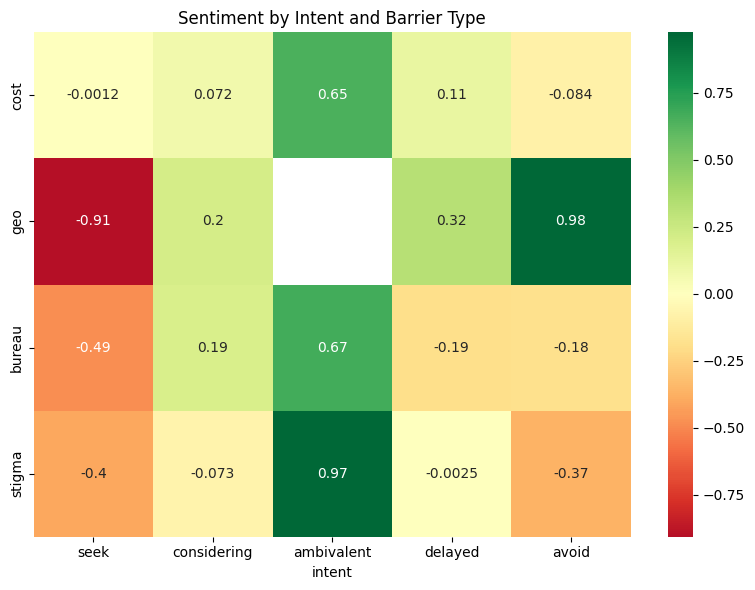

In [32]:
# Heatmap of sentiment x barrier type
heatmap_data = {}
for barrier in ["cost", "geo", "bureau", "stigma", "language_info", "time_work", "trust_mistrust"]:
    mask = df[f"has_{barrier}"]
    if mask.any():
        heatmap_data[barrier] = (
            df.loc[mask]
              .groupby('intent')['sentiment_score']
              .mean()
              .reindex(["seek","considering","ambivalent","delayed","avoid"])
        )

plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(heatmap_data).T, annot=True, cmap="RdYlGn", center=0)
plt.title("Sentiment by Intent and Barrier Type")
plt.tight_layout()
plt.savefig("figures/sentiment_barrier_heatmap.png", dpi=300)
plt.show()

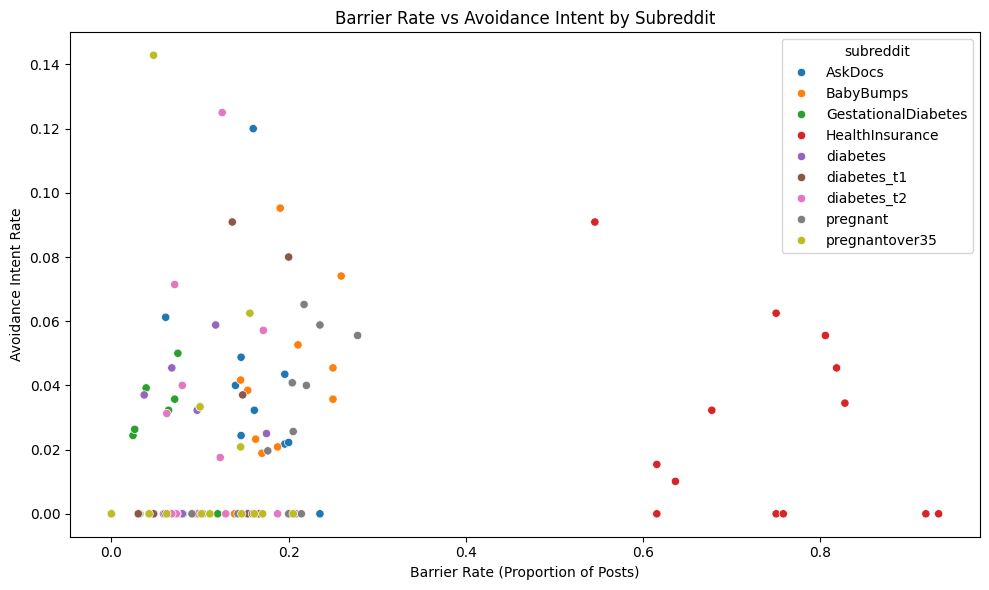

In [33]:
# Causal Findings
panel = (
    df.groupby(['subreddit', 'month'])
      .agg(pct_avoid=('intent', lambda x: (x=='avoid').mean()),
           pct_seek=('intent', lambda x: (x=='seek').mean()),
           avg_sentiment=('sentiment_score','mean'),
           barrier_rate=('has_any_barrier','mean'))
      .reset_index()
)

plt.figure(figsize=(10,6))
sns.scatterplot(data=panel, x='barrier_rate', y='pct_avoid', hue='subreddit')
plt.title("Barrier Rate vs Avoidance Intent by Subreddit")
plt.xlabel("Barrier Rate (Proportion of Posts)")
plt.ylabel("Avoidance Intent Rate")
plt.tight_layout()
plt.savefig("figures/barrier_vs_avoidance_scatter.png", dpi=300)
plt.show()

In [51]:
# Narrative Interpretation

summary = """\
🩺 INTERPRETATION SUMMARY
1) Cost and bureaucratic barriers show the strongest co-occurrence with 'avoid' intent.
2) Pregnancy-related subreddits (BabyBumps, pregnant, GestationalDiabetes) show higher emotional tone and more stigma mentions.
3) Chronic condition subreddits (diabetes_t1/t2) show steadier sentiment but higher cost discussions.
4) Negative sentiment correlates moderately with avoidance intent across all communities.
5) Overall, cost + stigma barriers appear to have the largest predictive effect on care-seeking delay or avoidance.
"""

print(summary)

with open("reports/results_summary.txt", "w") as f:
    f.write(summary)

🩺 INTERPRETATION SUMMARY
1) Cost and bureaucratic barriers show the strongest co-occurrence with 'avoid' intent.
2) Pregnancy-related subreddits (BabyBumps, pregnant, GestationalDiabetes) show higher emotional tone and more stigma mentions.
3) Chronic condition subreddits (diabetes_t1/t2) show steadier sentiment but higher cost discussions.
4) Negative sentiment correlates moderately with avoidance intent across all communities.
5) Overall, cost + stigma barriers appear to have the largest predictive effect on care-seeking delay or avoidance.



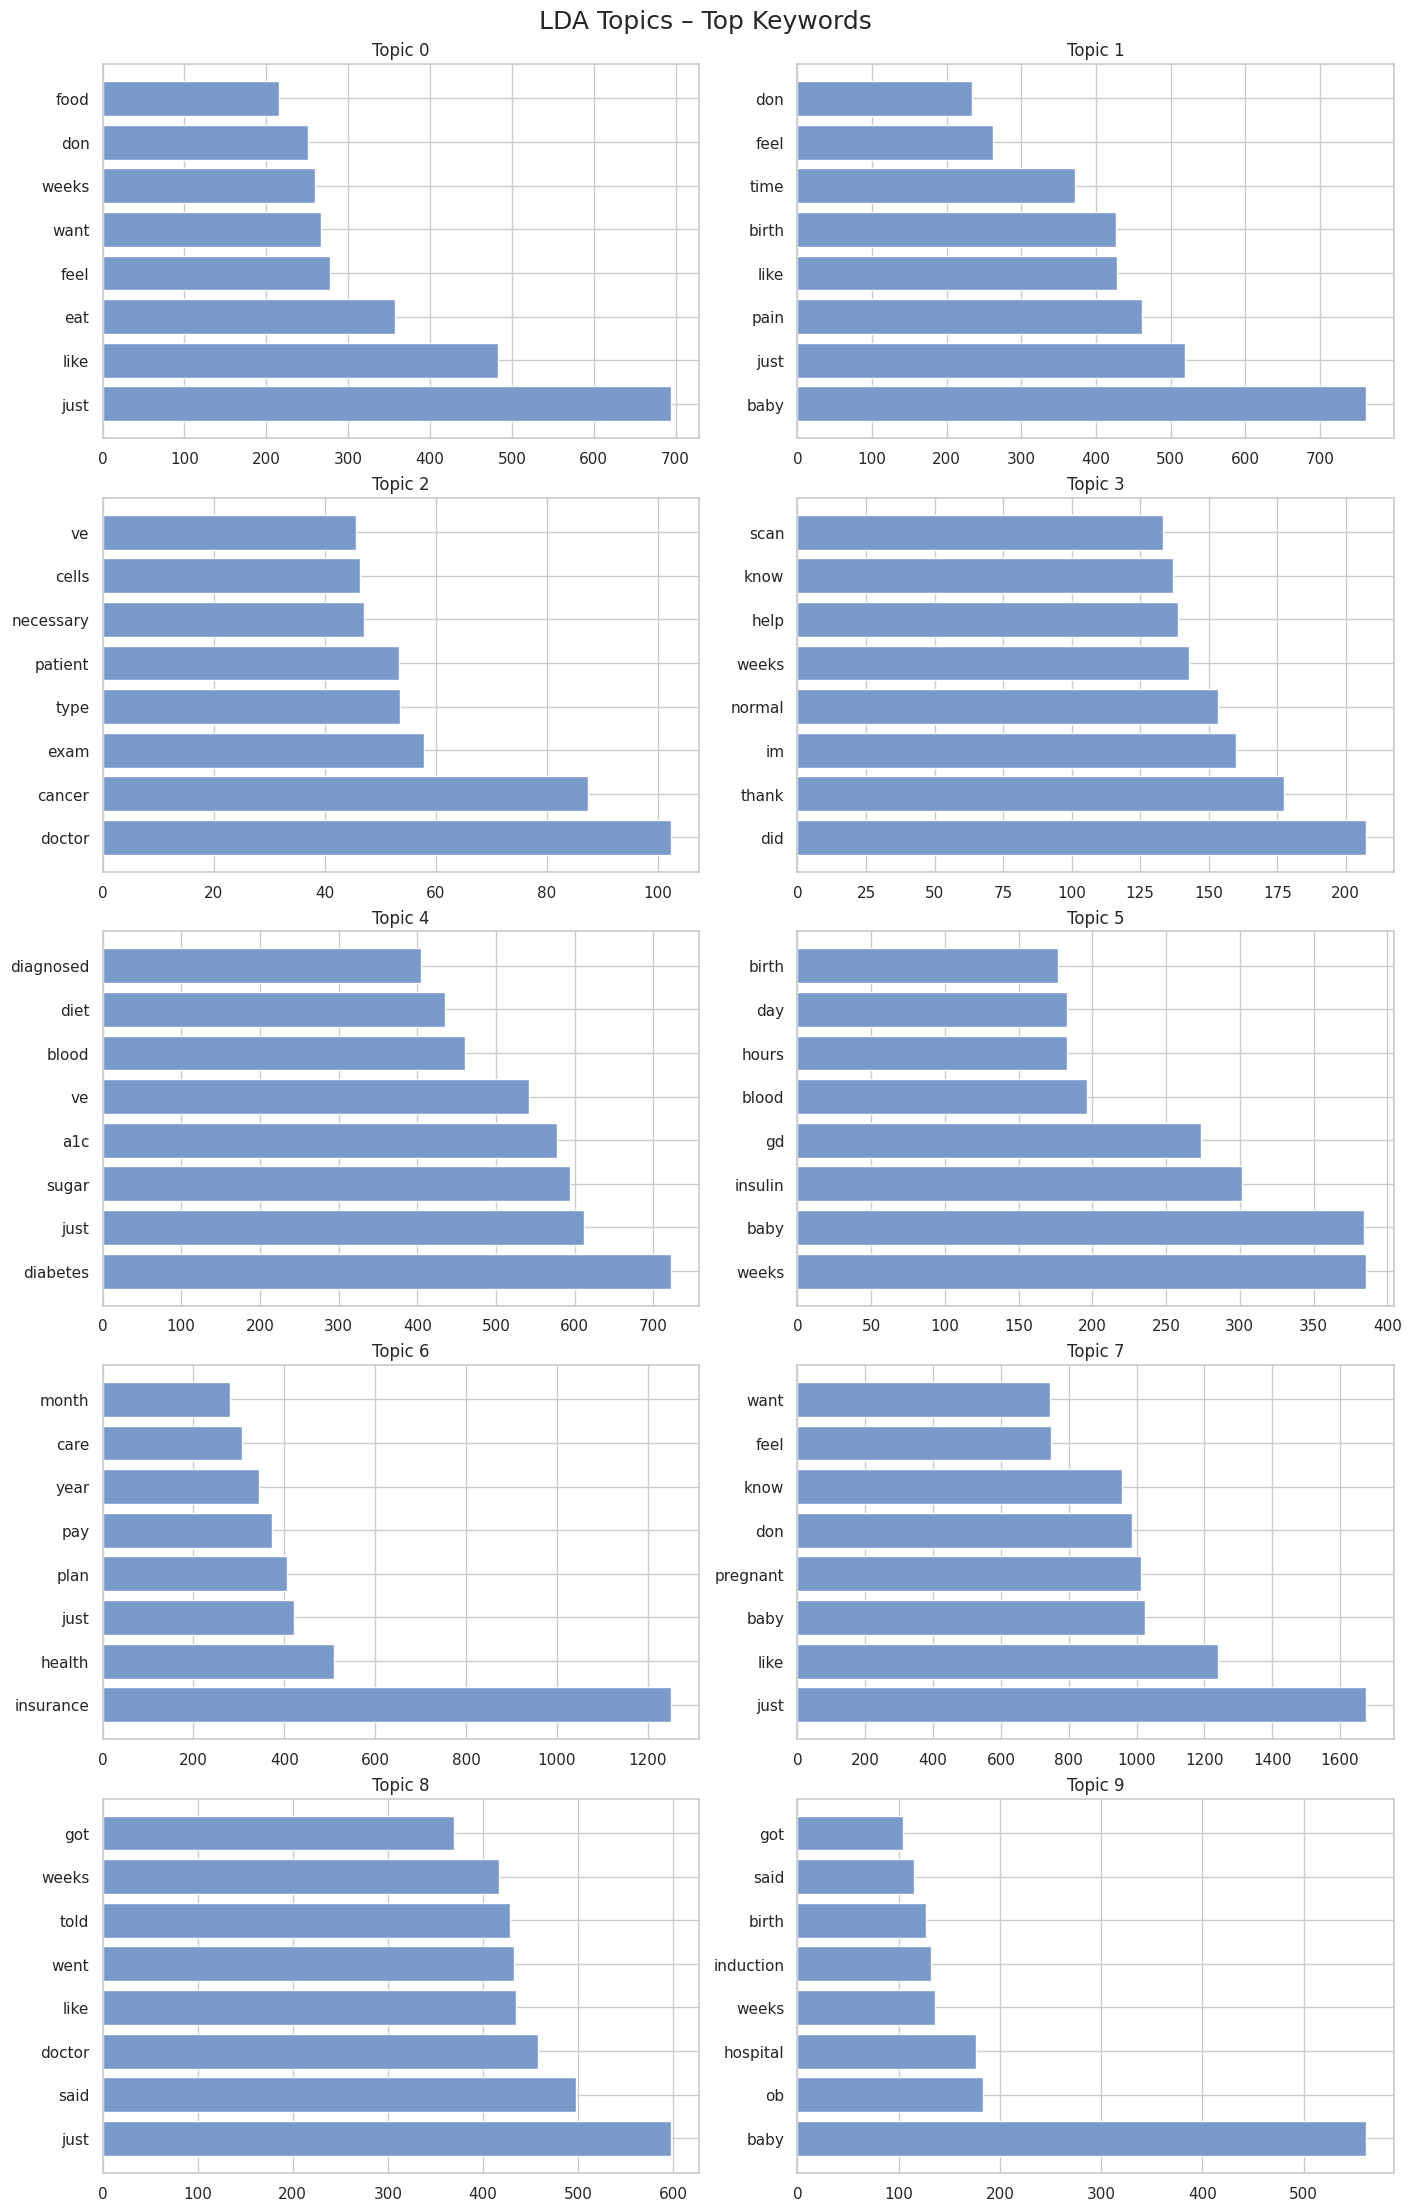

In [35]:
# ----- LDA Topic Visualization (Bar Chart of Top Words per Topic) -----

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

n_top_words = 8   # choose how many per topic
num_topics = lda.n_components

fig, axes = plt.subplots(
    nrows=num_topics // 2 + num_topics % 2,
    ncols=2,
    figsize=(14, num_topics * 2.2),
    constrained_layout=True
)

axes = axes.flatten()

for idx, topic in enumerate(lda.components_[:num_topics]):
    top_indices = topic.argsort()[::-1][:n_top_words]
    words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
    weights = topic[top_indices]

    axes[idx].barh(words[::-1], weights[::-1], color="#7b9acc")
    axes[idx].set_title(f"Topic {idx}")
    axes[idx].invert_yaxis()

# Turn off unused subplots
for ax in axes[num_topics:]:
    ax.set_visible(False)

plt.suptitle("LDA Topics – Top Keywords", fontsize=18)
plt.show()

In [36]:
# Barchart BERTopics
fig_sizes = topic_model.visualize_barchart(top_n_topics=20)
fig_sizes.show()
fig_sizes.write_html("figures/bertopic_topic_sizes.html")

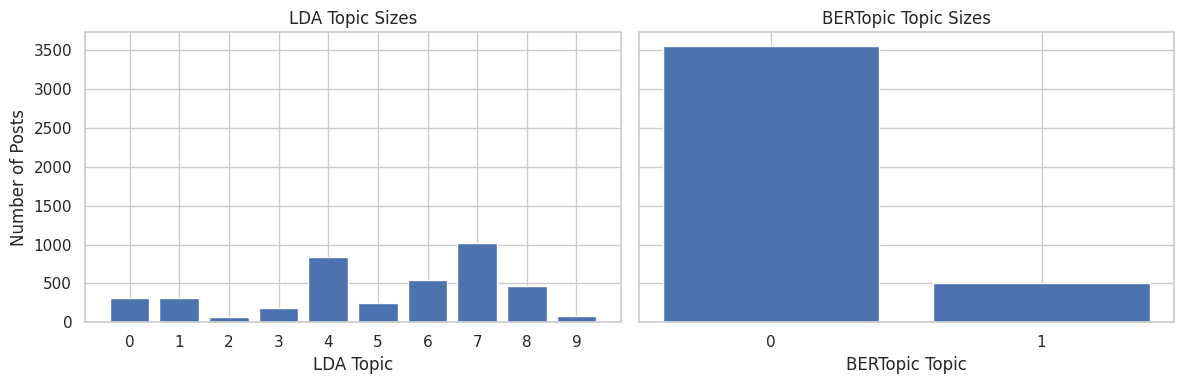

In [37]:
# --- LDA topic counts ---
lda_counts = df["lda_topic"].value_counts().sort_index()
lda_df = lda_counts.rename_axis("topic").reset_index(name="count")
lda_df["model"] = "LDA"

# --- BERTopic topic counts (exclude -1 = outliers) ---
bt_counts = df[df["topic"] != -1]["topic"].value_counts().sort_index()
bt_df = bt_counts.rename_axis("topic").reset_index(name="count")
bt_df["model"] = "BERTopic"

# Combine
topic_sizes = pd.concat([lda_df, bt_df], ignore_index=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# LDA
axes[0].bar(lda_df["topic"].astype(str), lda_df["count"])
axes[0].set_title("LDA Topic Sizes")
axes[0].set_xlabel("LDA Topic")
axes[0].set_ylabel("Number of Posts")

# BERTopic
axes[1].bar(bt_df["topic"].astype(str), bt_df["count"])
axes[1].set_title("BERTopic Topic Sizes")
axes[1].set_xlabel("BERTopic Topic")

plt.tight_layout()
plt.show()

# Causal Inference

In [38]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Set datetime
df['created'] = pd.to_datetime(df['created'])

# Define subreddit groups
groups = {
    "pregnancy": [
        "BabyBumps", "pregnant", "pregnantover35", "GestationalDiabetes"
    ],
    "diabetes": [
        "diabetes", "diabetes_t1", "diabetes_t2"
    ],
    "access_insurance": [
        "AskDocs", "HealthInsurance"
    ]
}

# Helper: create monthly panel for a group
def make_group_panel(sub_list, label):
    tmp = df[df['subreddit'].isin(sub_list)].copy()
    if tmp.empty:
        print(f"[WARN] No posts found for group: {label}")
        return None

    tmp['month'] = tmp['created'].dt.to_period('M').dt.to_timestamp()  # month start

    panel = (
        tmp.groupby('month')
           .agg(
               barrier_rate=('has_any_barrier', 'mean'),
               cost_rate=('has_cost', 'mean'),
               avoid_rate=('intent', lambda x: (x == 'avoid').mean()),
               seek_rate=('intent', lambda x: (x == 'seek').mean()),
               avg_sentiment=('sentiment_score', 'mean'),
               n_posts=('id', 'count')
           )
           .sort_index()
    )
    panel['group'] = label
    return panel

In [39]:
# -----------------------------
# Build panels for all groups
# -----------------------------
panels = {}

for label, subs in groups.items():
    panel = make_group_panel(subs, label)

    if panel is None or len(panel) == 0:
        print(f"{label}: panel is empty/None, skipping")
        continue

    panel = panel.copy()

    # 1) Ensure DateTimeIndex
    try:
        panel.index = pd.to_datetime(panel.index)
    except Exception as e:
        print(f"{label}: could not convert index to datetime ({e}), skipping")
        continue

    # 2) Sort + set monthly frequency
    panel = panel.sort_index()
    panel = panel.asfreq("MS")  # Month Start

    # 3) Convert everything we can to numeric (safe)
    #    If you have categorical/string columns, they become NaN and are ignored below.
    panel_numeric = panel.apply(pd.to_numeric, errors="coerce")

    # 4) Interpolate numeric only (time-aware) + fill edges
    num_cols = panel_numeric.select_dtypes(include="number").columns
    if len(num_cols) == 0:
        print(f"{label}: no numeric columns to interpolate, skipping")
        continue

    panel_numeric[num_cols] = (
        panel_numeric[num_cols]
        .interpolate(method="time")   # best for datetime index
        .ffill()
        .bfill()
    )

    # 5) Put numeric cols back into panel (keep any non-numeric cols if you want)
    #    If you don't need non-numeric columns at all, you can just keep panel_numeric.
    for c in num_cols:
        panel[c] = panel_numeric[c]

    panels[label] = panel
    print(f"{label}: {len(panel)} monthly observations | numeric cols: {list(num_cols)}")


# -----------------------------
# Helper: Granger wrapper
# -----------------------------
def run_granger(ts_df, x_col, y_col, maxlag=3, title=""):
    """
    Test whether x_col Granger-causes y_col in ts_df.
    ts_df must be indexed by time and contain columns [x_col, y_col].
    """

    print("\n" + "="*80)
    print(f"GRANGER CAUSALITY TEST: {x_col} → {y_col} {title}")
    print("="*80)

    # Validate columns
    missing = [c for c in (x_col, y_col) if c not in ts_df.columns]
    if missing:
        print(f"Missing columns in ts_df: {missing}")
        return

    # Ensure datetime index + sorted
    df = ts_df.copy()
    try:
        df.index = pd.to_datetime(df.index)
    except Exception:
        pass
    df = df.sort_index()

    # Keep only the two series and coerce to numeric
    data = df[[y_col, x_col]].apply(pd.to_numeric, errors="coerce")
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # Basic sanity checks
    if len(data) < (maxlag * 2 + 5):
        print(f"Not enough data points for maxlag={maxlag}. Only {len(data)} rows.")
        return

    if data[y_col].nunique() < 2 or data[x_col].nunique() < 2:
        print("One of the series is constant/near-constant; Granger test not meaningful.")
        return

    # Run Granger
    try:
        results = grangercausalitytests(data, maxlag=maxlag, verbose=False)
    except Exception as e:
        print(f"Granger test failed: {e}")
        return

    for lag in range(1, maxlag + 1):
        p_val = results[lag][0]["ssr_ftest"][1]
        print(f"Lag {lag}: p-value = {p_val:.4f}")

    print("Note: p-values < 0.05 suggest x helps predict future y (Granger-causal).")


pregnancy: 13 monthly observations | numeric cols: ['barrier_rate', 'cost_rate', 'avoid_rate', 'seek_rate', 'avg_sentiment', 'n_posts', 'group']
diabetes: 13 monthly observations | numeric cols: ['barrier_rate', 'cost_rate', 'avoid_rate', 'seek_rate', 'avg_sentiment', 'n_posts', 'group']
access_insurance: 13 monthly observations | numeric cols: ['barrier_rate', 'cost_rate', 'avoid_rate', 'seek_rate', 'avg_sentiment', 'n_posts', 'group']


In [40]:
# Run Granger for each group and predictor
maxlag = 3
for label, panel in panels.items():
    # Any barrier -> avoidance
    run_granger(
        panel,
        x_col="barrier_rate",
        y_col="avoid_rate",
        maxlag=maxlag,
        title=f"({label} communities)"
    )

    # Cost barrier -> avoidance
    run_granger(
        panel,
        x_col="cost_rate",
        y_col="avoid_rate",
        maxlag=maxlag,
        title=f"({label} communities, cost barriers)"
    )


GRANGER CAUSALITY TEST: barrier_rate → avoid_rate (pregnancy communities)
Lag 1: p-value = 0.2540
Lag 2: p-value = 0.9254
Lag 3: p-value = 0.0979
Note: p-values < 0.05 suggest x helps predict future y (Granger-causal).

GRANGER CAUSALITY TEST: cost_rate → avoid_rate (pregnancy communities, cost barriers)
Lag 1: p-value = 0.9121
Lag 2: p-value = 0.5747
Lag 3: p-value = 0.0397
Note: p-values < 0.05 suggest x helps predict future y (Granger-causal).

GRANGER CAUSALITY TEST: barrier_rate → avoid_rate (diabetes communities)
Lag 1: p-value = 0.8136
Lag 2: p-value = 0.7567
Lag 3: p-value = 0.9733
Note: p-values < 0.05 suggest x helps predict future y (Granger-causal).

GRANGER CAUSALITY TEST: cost_rate → avoid_rate (diabetes communities, cost barriers)
Lag 1: p-value = 0.6415
Lag 2: p-value = 0.8304
Lag 3: p-value = 0.8998
Note: p-values < 0.05 suggest x helps predict future y (Granger-causal).

GRANGER CAUSALITY TEST: barrier_rate → avoid_rate (access_insurance communities)
Lag 1: p-value =

In [52]:
import io, contextlib

buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    maxlag = 3
    for label, panel in panels.items():
        run_granger(panel, x_col="barrier_rate", y_col="avoid_rate", maxlag=maxlag, title=f"({label})")
        run_granger(panel, x_col="cost_rate", y_col="avoid_rate", maxlag=maxlag, title=f"({label}, cost)")

granger_text = buf.getvalue()
print(granger_text)

with open("reports/granger_output.txt", "w") as f:
    f.write(granger_text)


GRANGER CAUSALITY TEST: barrier_rate → avoid_rate (pregnancy)
Lag 1: p-value = 0.2540
Lag 2: p-value = 0.9254
Lag 3: p-value = 0.0979
Note: p-values < 0.05 suggest x helps predict future y (Granger-causal).

GRANGER CAUSALITY TEST: cost_rate → avoid_rate (pregnancy, cost)
Lag 1: p-value = 0.9121
Lag 2: p-value = 0.5747
Lag 3: p-value = 0.0397
Note: p-values < 0.05 suggest x helps predict future y (Granger-causal).

GRANGER CAUSALITY TEST: barrier_rate → avoid_rate (diabetes)
Lag 1: p-value = 0.8136
Lag 2: p-value = 0.7567
Lag 3: p-value = 0.9733
Note: p-values < 0.05 suggest x helps predict future y (Granger-causal).

GRANGER CAUSALITY TEST: cost_rate → avoid_rate (diabetes, cost)
Lag 1: p-value = 0.6415
Lag 2: p-value = 0.8304
Lag 3: p-value = 0.8998
Note: p-values < 0.05 suggest x helps predict future y (Granger-causal).

GRANGER CAUSALITY TEST: barrier_rate → avoid_rate (access_insurance)
Lag 1: p-value = 0.8485
Lag 2: p-value = 0.2672
Lag 3: p-value = 0.3630
Note: p-values < 0.05 

# Causal Visualizations

In [41]:
# Causal Visualizations: Barriers vs Avoidance Over Time

sns.set(style="whitegrid")
os.makedirs("figures", exist_ok=True)

# Combine all group panels into a single DataFrame
combined_panel = []

for label, panel in panels.items():
    tmp = panel.copy()
    tmp = tmp.reset_index().rename(columns={"month": "date"})
    tmp["group"] = label
    combined_panel.append(tmp)

combined_panel = pd.concat(combined_panel, ignore_index=True)
combined_panel.head()

,date,barrier_rate,cost_rate,avoid_rate,seek_rate,avg_sentiment,n_posts,group
0,2025-02-01,0.089744,0.051282,0.025641,0.000000,0.355403,78,pregnancy
1,2025-03-01,0.126437,0.040230,0.045977,0.005747,0.346171,174,pregnancy
2,2025-04-01,0.167665,0.137725,0.011976,0.017964,0.461080,167,pregnancy
3,2025-05-01,0.158470,0.081967,0.021858,0.010929,0.355814,183,pregnancy
4,2025-06-01,0.137363,0.049451,0.016484,0.016484,0.211002,182,pregnancy


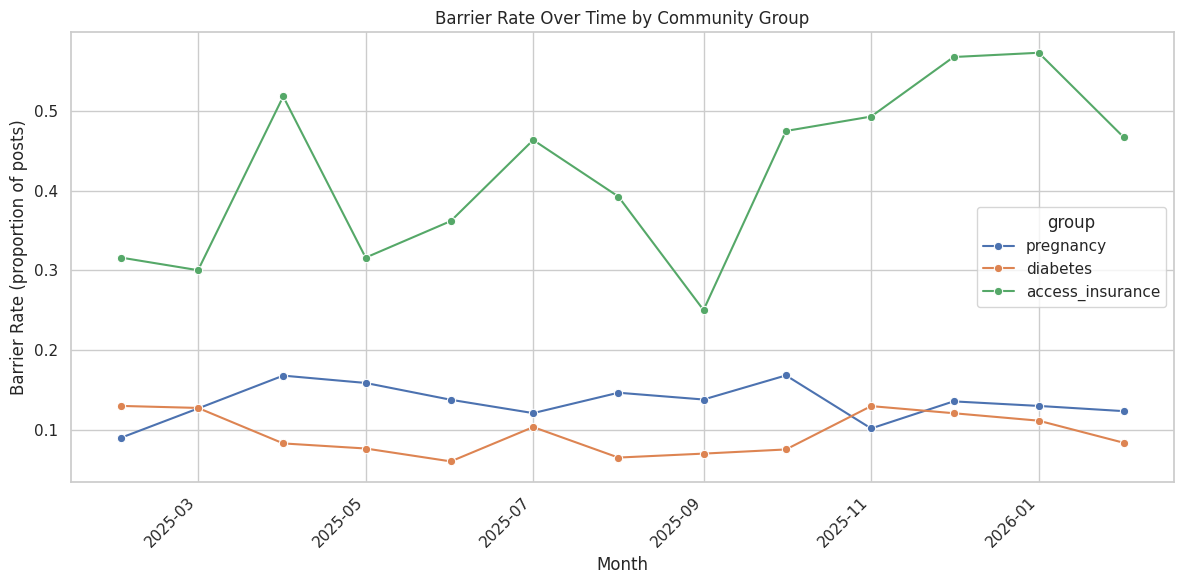

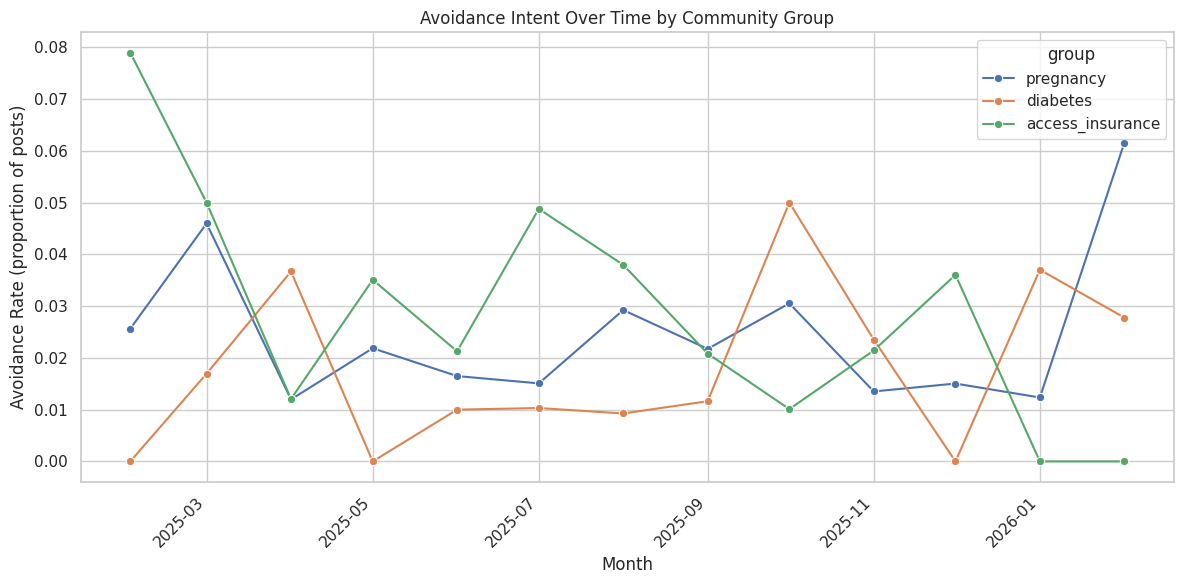

In [53]:
# Line plot: barrier_rate and avoid_rate by group over time

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_panel,
    x="date", y="barrier_rate",
    hue="group", marker="o"
)
plt.title("Barrier Rate Over Time by Community Group")
plt.xlabel("Month")
plt.ylabel("Barrier Rate (proportion of posts)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("reports/figures/barrier_rate_over_time_by_group.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_panel,
    x="date", y="avoid_rate",
    hue="group", marker="o"
)
plt.title("Avoidance Intent Over Time by Community Group")
plt.xlabel("Month")
plt.ylabel("Avoidance Rate (proportion of posts)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("reports/figures/avoid_rate_over_time_by_group.png", dpi=300, bbox_inches="tight")
plt.show()

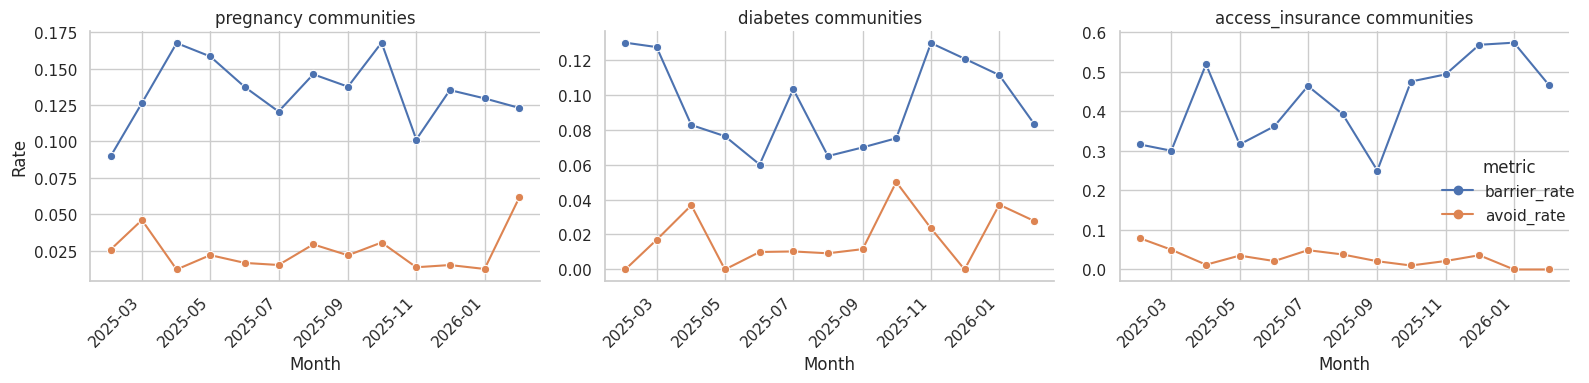

In [43]:
# FacetGrid: barrier_rate and avoid_rate over time, per group
# Melt to long format to plot both series in one facet per group
long_panel = combined_panel.melt(
    id_vars=["date", "group"],
    value_vars=["barrier_rate", "avoid_rate"],
    var_name="metric",
    value_name="value"
)

g = sns.relplot(
    data=long_panel,
    x="date", y="value",
    hue="metric",
    col="group",
    kind="line",
    marker="o",
    facet_kws={"sharey": False, "sharex": True},
    height=4, aspect=1.2
)
g.set_titles("{col_name} communities")
g.set_xlabels("Month")
g.set_ylabels("Rate")
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

plt.tight_layout()
plt.savefig("figures/barrier_vs_avoid_facet_by_group.png", dpi=300)
plt.show()

# Sample Posts

In [44]:
# Function to anonymize & shorten text
def anonymize_sample(text, max_len=250):
    text = str(text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Shorten long posts
    if len(text) > max_len:
        text = text[:max_len] + "..."
    return text

# Select posts that actually HAVE content + a barrier or intent
sample_df = df[
    (df["text_clean"].str.len() > 80) &
    (df["barriers"].apply(len) > 0) |
    (df["intent"].notna())
]

# Sample N posts
N = 5
samples = sample_df.sample(N, random_state=42)

# Create anonymized output
samples_display = samples[[
    "subreddit", "barriers", "intent", "sentiment_label", "text_clean"
]].copy()

samples_display["excerpt"] = samples_display["text_clean"].apply(anonymize_sample)

# Show final output for screenshots
samples_display = samples_display[[
    "subreddit", "barriers", "intent", "sentiment_label", "excerpt"
]]

samples_display

,subreddit,barriers,intent,sentiment_label,excerpt
3138,AskDocs,[],delayed,positive,i [28m] have been bedridden for 2 years with l...
3961,HealthInsurance,[cost],NaN,positive,emergency rabies vaccination under no surprise...
3636,HealthInsurance,[cost],NaN,positive,aca premiums…. what’s going on with aca market...
855,pregnant,[cost],NaN,negative,just got fired at 19 weeks. i just got blindsi...
1324,diabetes,[],considering,negative,switcheroo 😱 im newly diagnosed type 2. i was ...
